In [1]:
### Import Libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

### Trainning Data 

In [2]:
df=pd.read_excel(r"NLP Engineer -Train&val Dataset.xlsx",engine='openpyxl')
df.head()

,Conversations,Patient Or not
0,I don't disagree with you in principle. I'm ju...,0
1,I am always dizzy I get dizzy standing up so I...,1
2,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0
3,I am 17 and I have been throwing up for about ...,1
4,Quote: Originally Posted by Boyan Silyavski Wa...,0


In [3]:
##Check null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Conversations   1000 non-null   object
 1   Patient Or not  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


## 1. Text Processing:

In [4]:
## Remove Contractions
import contractions

def remove_contractions(text):
    contr_text=contractions.fix(text)
    return contr_text

## Remove Diacritics
import unidecode

def remove_diacritics(text):
    dia_text = unidecode.unidecode(text) 
    return dia_text

## Remove URLs
import re

def remove_url(text):
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) 
    return text

## Remove HTML
from bs4 import BeautifulSoup

def remove_html(text):
    text = BeautifulSoup(text, 'html5lib').get_text() 
    return text

## Tokenizer
import nltk
from nltk import word_tokenize

def nlp_tokenizer(text):
    word_tokens = word_tokenize(text)
    return word_tokens

## Remove Stopwords
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

## Spell Check or Grammar Check
from textblob import TextBlob

def spell_checker(text):
    b = TextBlob(text) 
    return str(b.correct())

###Stemming
from nltk.stem import PorterStemmer
porter_stemmer=PorterStemmer()

    
def stemming(text):
    word_tokens=nlp_tokenizer(text)
    stemmed_words=[porter_stemmer.stem(word=word) for word in word_tokens]
    return stemmed_words


##Lemmatize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemma(text):
    word_tokens=nlp_tokenizer(text)
    lemmatized_words=[lemmatizer.lemmatize(word=word,pos='v') for word in word_tokens]
    return lemmatized_words


## POS & Lemmatization
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

def remove_noise(text):
    text = re.sub('\W+','', text )
    return text
  

##1. Lower text  
##2. Remove Stopwords
##3. Remove Unwanted Digits
##4. Remove Punctuation
##5. Remove whitespace
import string

def basic_cleaning(text):
    text=text.lower()
    word_tokens=nlp_tokenizer(text)
    text = [x for x in word_tokens if
            (x not in stop_words and x not in string.punctuation and not x.isdigit())]
    text = ' '.join(text)
    text= text.strip()
    return text

[nltk_data] Downloading package wordnet to /home/azure/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def preprocessing(text):
    text = BeautifulSoup(text, 'html5lib').get_text() 
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) 
    text=contractions.fix(text)
    text = unidecode.unidecode(text) 
    b = TextBlob(text) 
    text=basic_cleaning(str(b))
    text = re.sub('\W+',' ', text )
    text=lemmatize_words(text)
    return text

df['clean_Conversations']=df['Conversations'].apply(lambda x:preprocessing(x) )



## 2. Extract Information

### Extract Email

In [6]:
def extract_email(text):
    emails = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", text)
    return emails

In [7]:
df['email']=df['Conversations'].apply(lambda x:extract_email(x) )
df['email_len']=df['email'].apply(lambda x: len(x))

In [8]:
##Display Email
df['email'][df['email_len']>0]

99                                 [invimafv@invima.gov]
112                             [media@divinebounty.com]
222               [sales@transparencymarketresearch.com]
229                               [media@vitabreeze.com]
278                       [ostovarsina.sina@blogger.com]
279                       [press@researchandmarkets.com]
301                                 [ool@email.chop.edu]
322                                [mgwarrier@gmail.com]
344                                    [ndo@fda.hhs.gov]
377                             [mcrisostomo@sacbee.com]
429                               [marc.kaplan@case.edu]
433                                   [wsj531@yahoo.com]
612                               [pmay@mercurynews.com]
690                   [jharrington@bayareanewsgroup.com]
785    [lerts@sp.healthafter50.com, harris_curtis@sbc...
Name: email, dtype: object

### NER

In [9]:
import spacy
import collections

In [10]:
## call model
ner = spacy.load("en_core_web_sm")
## tag text
txt = df["Conversations"].iloc[0]
doc = ner(txt)
## display result
spacy.displacy.render(doc, style="ent")

In [11]:
## tag text and exctract tags into a list
df["tags"] = df["clean_Conversations"].apply(lambda x: [(tag.text, tag.label_) for tag in ner(x).ents] )

In [12]:
##  function to count the element of a list
def lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

## count tags
df["tags"] = df["tags"].apply(lambda x: lst_count(x))

## utils function create new column for each tag category
def ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

## extract features
tags_set = []
for lst in df["tags"].tolist():
    for dic in lst:
        for k in dic.keys():
            tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     df["tags_"+feature] = df["tags"].apply(lambda x: 
                             ner_features(x, feature))

## print result
df.head()

,Conversations,Patient Or not,clean_Conversations,email,email_len,tags,tags_PRODUCT,tags_FAC,tags_MONEY,tags_ORG,...,tags_LAW,tags_EVENT,tags_PERCENT,tags_QUANTITY,tags_GPE,tags_WORK_OF_ART,tags_LANGUAGE,tags_ORDINAL,tags_TIME,tags_DATE
0,I don't disagree with you in principle. I'm ju...,0,disagree principle say entresto major failure ...,[],0,"[{('q1', 'CARDINAL'): 1}, {('entresto unveil n...",1,0,0,3,...,0,0,0,0,0,0,0,0,0,1
1,I am always dizzy I get dizzy standing up so I...,1,always dizzy get dizzy standing make get slow ...,[],0,"[{('every day', 'DATE'): 1}, {('around 94', 'C...",0,0,0,1,...,0,0,0,0,1,0,0,0,0,3
2,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0,axelle bauer griffin filmmagic new york queen ...,[],0,"[{('six million', 'CARDINAL'): 2}, {('axelle b...",0,1,0,3,...,0,0,0,0,1,0,0,0,0,2
3,I am 17 and I have been throwing up for about ...,1,throw year almost everyday thrown blood twice ...,[],0,"[{('throw year almost everyday', 'DATE'): 1}, ...",0,0,0,2,...,0,0,0,1,0,0,0,0,1,4
4,Quote: Originally Posted by Boyan Silyavski Wa...,0,quote originally post boyan silyavski wake fri...,[],0,"[{('boyan silyavski', 'PERSON'): 1}, {('hf', '...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 3. Sentiment Analysis

In [13]:
df["sentiment"] = df["clean_Conversations"].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,Conversations,Patient Or not,clean_Conversations,email,email_len,tags,tags_PRODUCT,tags_FAC,tags_MONEY,tags_ORG,...,tags_EVENT,tags_PERCENT,tags_QUANTITY,tags_GPE,tags_WORK_OF_ART,tags_LANGUAGE,tags_ORDINAL,tags_TIME,tags_DATE,sentiment
0,I don't disagree with you in principle. I'm ju...,0,disagree principle say entresto major failure ...,[],0,"[{('q1', 'CARDINAL'): 1}, {('entresto unveil n...",1,0,0,3,...,0,0,0,0,0,0,0,0,1,-0.071096
1,I am always dizzy I get dizzy standing up so I...,1,always dizzy get dizzy standing make get slow ...,[],0,"[{('every day', 'DATE'): 1}, {('around 94', 'C...",0,0,0,1,...,0,0,0,1,0,0,0,0,3,-0.060000
2,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0,axelle bauer griffin filmmagic new york queen ...,[],0,"[{('six million', 'CARDINAL'): 2}, {('axelle b...",0,1,0,3,...,0,0,0,1,0,0,0,0,2,0.060190
3,I am 17 and I have been throwing up for about ...,1,throw year almost everyday thrown blood twice ...,[],0,"[{('throw year almost everyday', 'DATE'): 1}, ...",0,0,0,2,...,0,0,1,0,0,0,0,1,4,0.078533
4,Quote: Originally Posted by Boyan Silyavski Wa...,0,quote originally post boyan silyavski wake fri...,[],0,"[{('boyan silyavski', 'PERSON'): 1}, {('hf', '...",0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.247917


### Sentiment Polarity

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

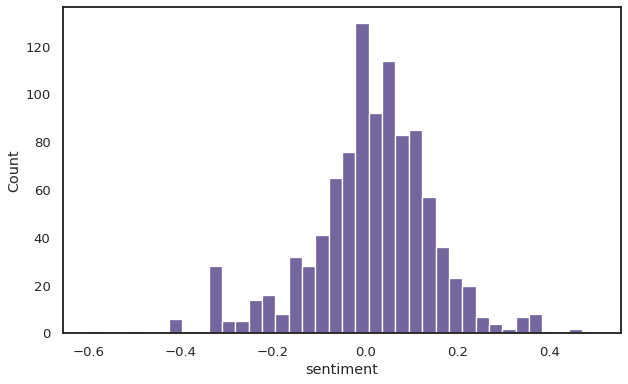

In [14]:
sns.histplot(df['sentiment'])

## 4. Tables

1. Word Frequency Table : counts the number of tokens in the text
2. Word Frequency – Normalization with the maximum frequency available 
3. Sentence Frequency Table :count the number of sentences (separated by a period)
4. Sentence Frequency - Normalization with the maximum frequency available 

In [15]:
df['word_freq'] = df["Conversations"].apply(lambda x: len(str(x).split(" ")))
df['sentence_freq'] = df["Conversations"].apply(lambda x: len(str(x).split(".")))
max_word_freq=max(df['word_freq'])
max_sent_freq=max(df['sentence_freq'])
df['norm_word_freq'] = df['word_freq'] / max_word_freq
df['norm_sentence_freq'] = df['sentence_freq'] / max_sent_freq
df.head()


,Conversations,Patient Or not,clean_Conversations,email,email_len,tags,tags_PRODUCT,tags_FAC,tags_MONEY,tags_ORG,...,tags_WORK_OF_ART,tags_LANGUAGE,tags_ORDINAL,tags_TIME,tags_DATE,sentiment,word_freq,sentence_freq,norm_word_freq,norm_sentence_freq
0,I don't disagree with you in principle. I'm ju...,0,disagree principle say entresto major failure ...,[],0,"[{('q1', 'CARDINAL'): 1}, {('entresto unveil n...",1,0,0,3,...,0,0,0,0,1,-0.071096,349,27,0.132197,0.068702
1,I am always dizzy I get dizzy standing up so I...,1,always dizzy get dizzy standing make get slow ...,[],0,"[{('every day', 'DATE'): 1}, {('around 94', 'C...",0,0,0,1,...,0,0,0,0,3,-0.060000,104,7,0.039394,0.017812
2,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0,axelle bauer griffin filmmagic new york queen ...,[],0,"[{('six million', 'CARDINAL'): 2}, {('axelle b...",0,1,0,3,...,0,0,0,0,2,0.060190,317,19,0.120076,0.048346
3,I am 17 and I have been throwing up for about ...,1,throw year almost everyday thrown blood twice ...,[],0,"[{('throw year almost everyday', 'DATE'): 1}, ...",0,0,0,2,...,0,0,0,1,4,0.078533,418,30,0.158333,0.076336
4,Quote: Originally Posted by Boyan Silyavski Wa...,0,quote originally post boyan silyavski wake fri...,[],0,"[{('boyan silyavski', 'PERSON'): 1}, {('hf', '...",0,0,0,0,...,0,0,0,0,1,0.247917,73,11,0.027652,0.027990


In [16]:
df_freq=df[['word_freq', 'sentence_freq',
       'norm_word_freq', 'norm_sentence_freq']]

In [17]:
df_freq.head()

,word_freq,sentence_freq,norm_word_freq,norm_sentence_freq
0,349,27,0.132197,0.068702
1,104,7,0.039394,0.017812
2,317,19,0.120076,0.048346
3,418,30,0.158333,0.076336
4,73,11,0.027652,0.027990


/home/azure/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/azure/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/azure/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

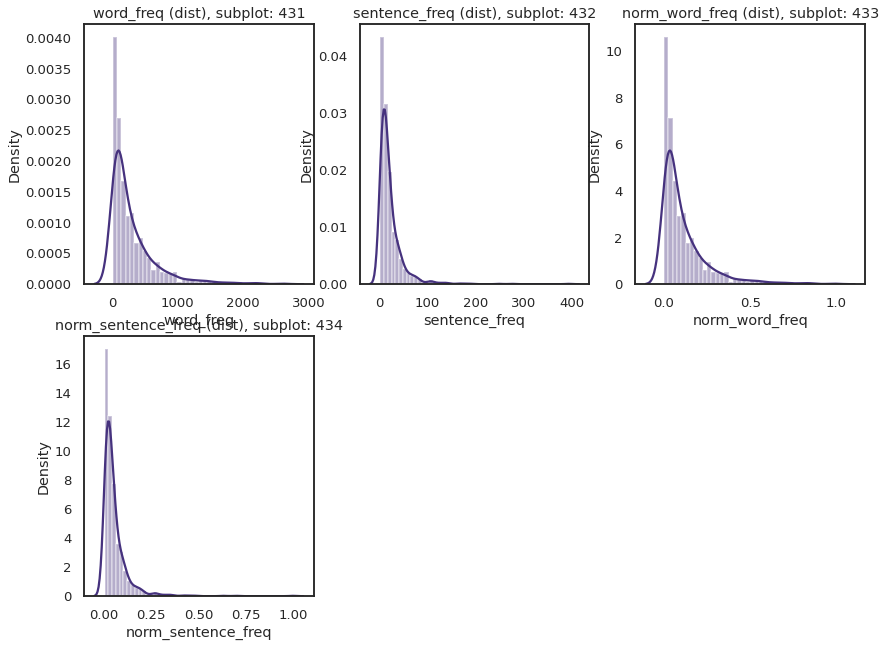

In [18]:
#  plot Numerical Data
a = 4  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,22))

for i in df_freq:
    plt.subplot(a, b, c)
    plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.distplot(df_freq[i])
    c = c + 1

## 5. Features


### 1. N-grams (1-4)

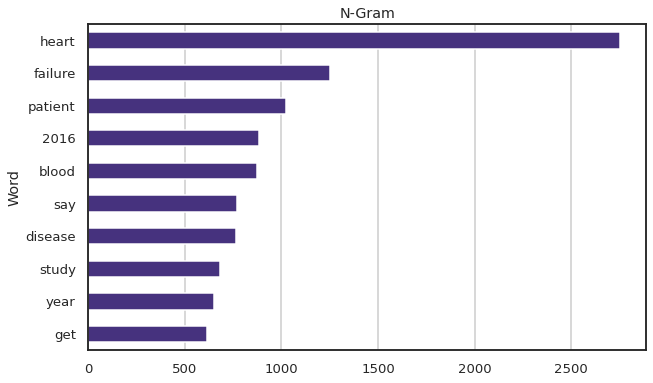

In [19]:
top=10
corpus = df["clean_Conversations"]
lst_tokens = word_tokenize(corpus.str.cat(sep=" "))

## 1-grams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 1))
ndf = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
ndf["Word"] = ndf["Word"].apply(lambda x: " ".join(string for string in x) )
ndf.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="N-Gram",legend=False).grid(axis='x')
plt.show()


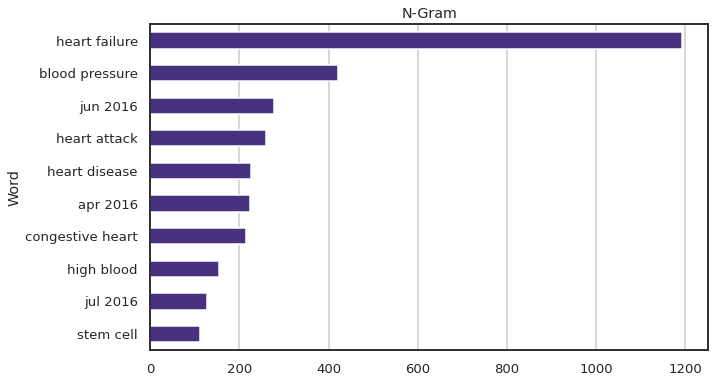

In [20]:
## 2-grams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
ndf = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
ndf["Word"] = ndf["Word"].apply(lambda x: " ".join(string for string in x) )
ndf.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="N-Gram",legend=False).grid(axis='x')
plt.show()

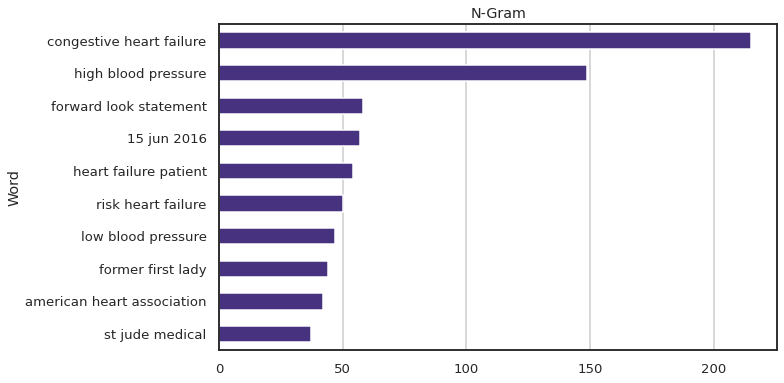

In [21]:
## 3-grams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 3))
ndf = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
ndf["Word"] = ndf["Word"].apply(lambda x: " ".join(string for string in x) )
ndf.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="N-Gram",legend=False).grid(axis='x')
plt.show()

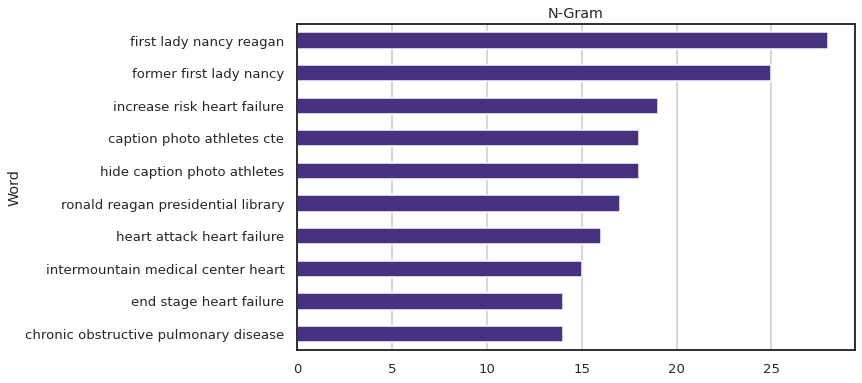

In [22]:
## 4-grams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 4))
ndf = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
ndf["Word"] = ndf["Word"].apply(lambda x: " ".join(string for string in x) )
ndf.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="N-Gram",legend=False).grid(axis='x')
plt.show()

### 2. Map words into Vectors, TF-IDF

Term Frequency-Inverse Document Frequency is a numerical statistic that demonstrates how important a word is to a corpus.


In [23]:
from sklearn.model_selection import train_test_split
TF_train,TF_val=train_test_split(df, test_size=0.2,random_state=7,stratify = df['Patient Or not']) 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x_tfidf = v.fit_transform(df['clean_Conversations'])

### 3. Kmeans to cluster based on the content and tfIdf, with support words in table or visuals

In [25]:
from sklearn.cluster import KMeans

number_of_clusters=2

kmeans = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init=1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

kmeans.fit(x_tfidf)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [26]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = v.get_feature_names()

In [27]:
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 heart
 patient
 blood
 study
 disease
 risk
 failure
 reagan
 pressure
 drug
Cluster 1:
 heart
 2016
 jun
 failure
 go
 get
 would
 jul
 year
 say


In [28]:
y_kmeans = kmeans.fit_predict(x_tfidf)

## 6. Visualizations:


### PCA an TSNE PLOT

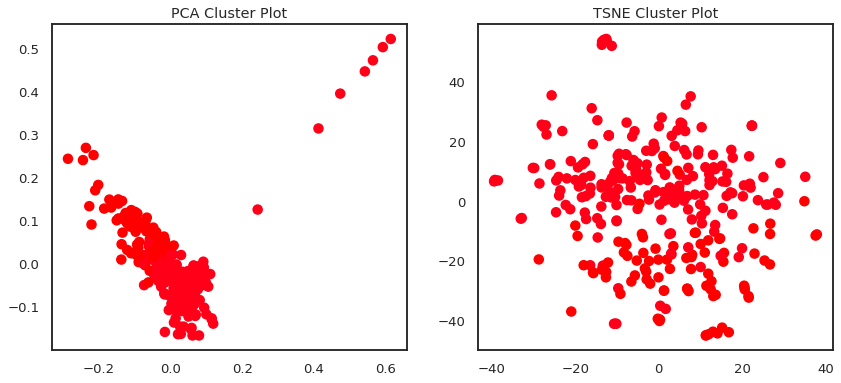

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=1000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(x_tfidf, y_kmeans)

In [30]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

print("Top 20 keywords in Kmeans Cluster") 
print("##################################")
get_top_keywords(x_tfidf, y_kmeans, v.get_feature_names(), 10)

Top 20 keywords in Kmeans Cluster
##################################

Cluster 0
drug,vitamin,failure,pressure,disease,risk,study,blood,patient,heart

Cluster 1
jul,year,would,say,get,go,jun,failure,2016,heart


In [31]:
def get_bottom_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[:n_terms]]))
print("Bottom 20 keywords in Kmeans Cluster") 
print("##################################")
get_bottom_keywords(x_tfidf, y_kmeans, v.get_feature_names(), 10)

Bottom 20 keywords in Kmeans Cluster
##################################

Cluster 0
zytrexa,idealistic,ideas,identifies,teary,identity,ideological,idiot,idiots,idk

Cluster 1
corviamedical,developer,oscillometric,oseni,detrunorm,detrol,oslo,detrimental,detoxifies,osmotic


###  Top 20 and Bottom 20 words for each class

In [32]:
from wordcloud import WordCloud

In [33]:
patient_words =' '.join([text for text in df['clean_Conversations'][df['Patient Or not'] == 1]])
not_patient_words =' '.join([text for text in df['clean_Conversations'][df['Patient Or not'] == 0]])

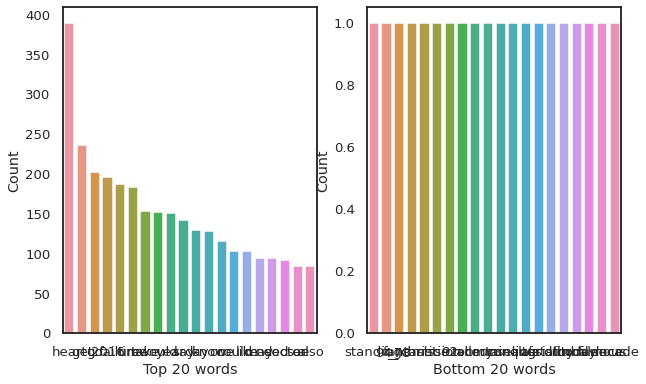

In [34]:
patient_tokens = word_tokenize(patient_words)
patient_tokens_freq = nltk.FreqDist(patient_tokens)
d_patient = pd.DataFrame({'Pateint Words': list(patient_tokens_freq.keys()),
                  'Count': list(patient_tokens_freq.values())})

# selecting top 10 most frequent hashtags     
d1_patient = d_patient.nlargest(columns="Count", n = 20) 
d2_patient = d_patient.nsmallest(columns="Count", n = 20) 

fig,(ax1,ax2) = plt.subplots(1,2)

sns.barplot(data=d1_patient, x="Pateint Words",y="Count",ax=ax1)
sns.barplot(data=d2_patient, x="Pateint Words",y = "Count",ax=ax2)

ax1.set(ylabel = 'Count',xlabel='Top 20 words')
ax2.set(ylabel = 'Count',xlabel='Bottom 20 words')

plt.show()



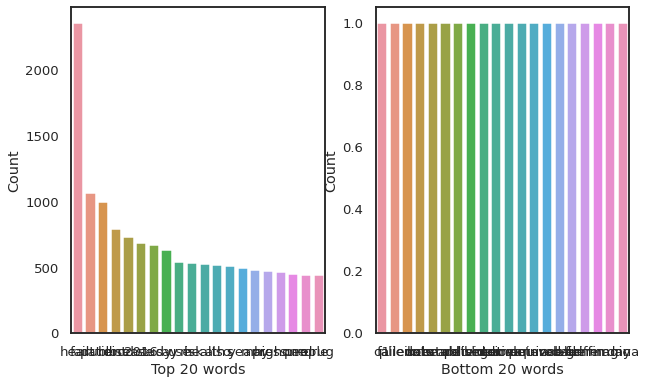

In [35]:
not_patient_tokens = word_tokenize(not_patient_words)
not_patient_freq = nltk.FreqDist(not_patient_tokens)
d_not_patient = pd.DataFrame({'Non-Pateint Words': list(not_patient_freq.keys()),
                  'Count': list(not_patient_freq.values())})


# selecting top 10 most frequent hashtags     
d1_not_patient = d_not_patient.nlargest(columns="Count", n = 20) 
d2_not_patient = d_not_patient.nsmallest(columns="Count", n = 20) 

fig,(ax1,ax2) = plt.subplots(1,2)

sns.barplot(data=d1_not_patient, x="Non-Pateint Words",y="Count",ax=ax1)
sns.barplot(data=d2_not_patient, x="Non-Pateint Words",y = "Count",ax=ax2)

ax1.set(ylabel = 'Count',xlabel='Top 20 words')
ax2.set(ylabel = 'Count',xlabel='Bottom 20 words')

plt.show()

### Wordcloud

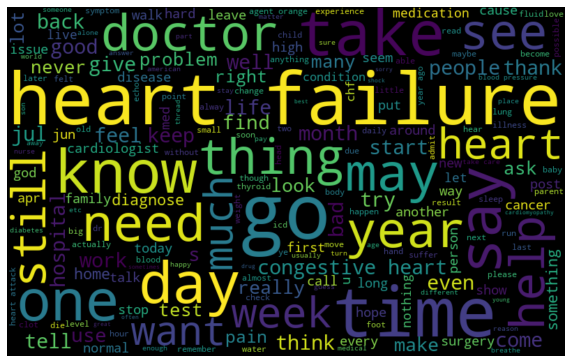

In [36]:


wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(patient_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

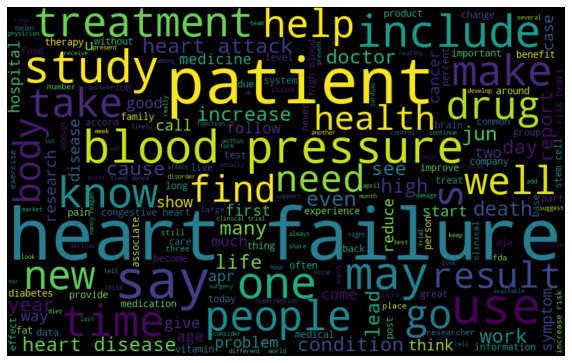

In [37]:


wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(not_patient_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 7. Summarization:


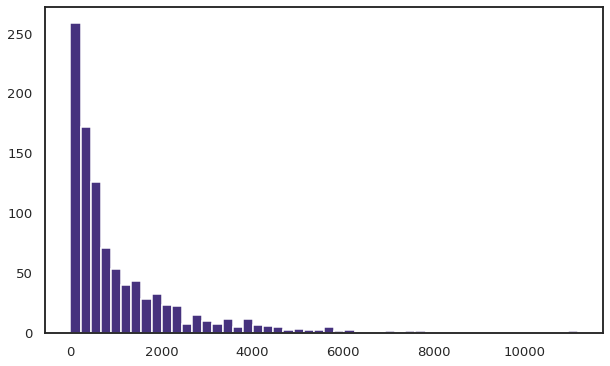

In [38]:
### Conversations length distribution

sentences=df['clean_Conversations'].to_list()
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

### 1. Summarizer using T5ForConditionalGeneration

In [50]:
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cpu')




preprocess_text = text.strip().replace("\n","")
t5_prepared_Text = "summarize: "+preprocess_text
print ("original text preprocessed: \n", preprocess_text)

tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)


# summmarize 
summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=30,
                                    max_length=100,
                                    early_stopping=True)

output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\nSummarized text: \n",output)

original text preprocessed: 
 sleep disorder may predict heart event angioplasty people percutaneous coronary intervention pci also know angioplasty acute coronary syndrome could higher risk death heart failure heart attack stroke sleep disordered breathe sleep apnea accord new research journal american heart association open access journal american heart association american stroke association people percutaneous coronary intervention pci also know angioplasty acute coronary syndrome could higher risk death heart failure heart attack stroke hour ago medical xpress 15 jun 2016


/home/azure/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)




Summarized text: 
 sleep disordered breathe sleep apnea accord new research journal american heart association american stroke association people percutaneous coronary intervention pci also know angioplasty.


In [72]:
# !pip install bert-extractive-summarizer

### 2. Summraizer using BERT

In [73]:
import torch
from summarizer import Summarizer

text =df['clean_Conversations'][8]
bert_model = Summarizer()
bert_summary = ''.join(bert_model(text, ratio=0.3))



### 3. Summarizer using GPT2

In [74]:
from summarizer import TransformerSummarizer
GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")
full = ''.join(GPT2_model(text, ratio=0.3))

## 8. Modeling & Tuning:

### 1. Train & Val Dataset Split  [Train-80%, Validation-20%]

In [54]:
from sklearn.model_selection import train_test_split
Train,Val=train_test_split(df, test_size=0.2,random_state=7,stratify = df['Patient Or not']) 

Train.shape,Val.shape

((800, 29), (200, 29))

### 2. Model - Naive Bayes

### 1. Data Imbalance Check

0    800
1    200
Name: Patient Or not, dtype: int64


/home/azure/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Patient Or not', ylabel='count'>

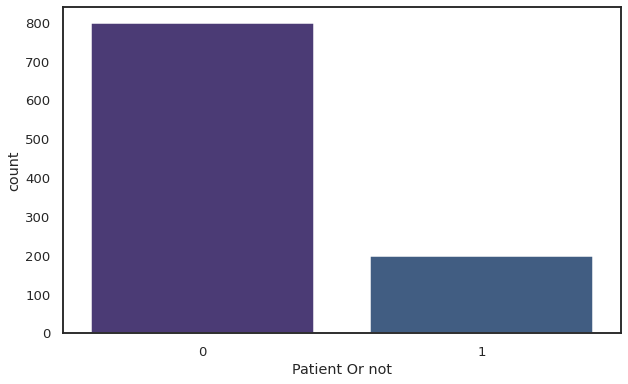

In [55]:
##Each class count
print(df['Patient Or not'].value_counts())
sns.countplot(df['Patient Or not'])

1    800
0    800
Name: Patient Or not, dtype: int64


/home/azure/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Patient Or not', ylabel='count'>

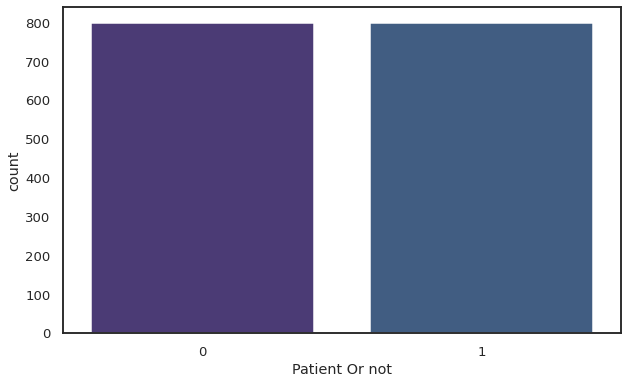

In [56]:
### UpSampling
from sklearn.utils import resample
# separate minority and majority classes
non_pat = df[df['Patient Or not']==0]
pat = df[df['Patient Or not']==1]

# upsample minority
pat_upsampled = resample(pat,
                          replace=True, # sample with replacement
                          n_samples=len(non_pat), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([non_pat, pat_upsampled])

# check new class counts
print(upsampled['Patient Or not'].value_counts())
sns.countplot(upsampled['Patient Or not'])

### 2. Data Split

In [57]:
from sklearn.model_selection import train_test_split
Train,Val=train_test_split(upsampled, test_size=0.2,random_state=7,stratify = upsampled['Patient Or not']) 

Train.shape,Val.shape

((1280, 29), (320, 29))

### 3. Model Fine Tuning

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [71]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB(fit_prior=True, class_prior=None)),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__alpha': (1e-2, 1e-3)
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=10, n_jobs=2, verbose=1)
grid_search_tune.fit(Train['clean_Conversations'].to_list(), y_train)

print("Best parameters set:")
print (grid_search_tune.best_estimator_.steps)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters set:
[('tfidf', TfidfVectorizer(max_df=0.25, ngram_range=(1, 3))), ('clf', MultinomialNB(alpha=0.001))]


/home/azure/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### 3. Vectorizer

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


v = TfidfVectorizer(max_df=0.25, ngram_range=(1, 3))
x_train_tfidf = v.fit_transform(Train['clean_Conversations'].to_list())
x_val_tfidf=v.transform(Val['clean_Conversations'].to_list())

encoder = LabelEncoder()
encoder.fit(Train['Patient Or not'].to_list())

y_train = encoder.transform(Train['Patient Or not'].to_list())
y_val = encoder.transform(Val['Patient Or not'].to_list())

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_val.shape)

y_train shape: (1280, 1)
y_test shape: (320, 1)


### 4. Model Building

In [76]:
nb=MultinomialNB(alpha=0.001)
nb.fit(x_train_tfidf,y_train)
y_pred=nb.predict(x_val_tfidf)

/home/azure/.pyenv/versions/3.6.5/envs/jupyter/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### 5. Model Evalution

In [82]:
from sklearn.metrics import classification_report,accuracy_score, f1_score, confusion_matrix, recall_score

In [83]:
# f1 score
f1_score(list(Val['Patient Or not']), y_pred)

0.9433962264150944

In [84]:
##Recall score
recall_score(list(Val['Patient Or not']), y_pred)

0.9375

In [85]:
# Checking accuracy
accuracy_score(list(Val['Patient Or not']), y_pred)

0.94375

### Classification Report

In [86]:
print(classification_report(list(Val['Patient Or not']), y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       160
           1       0.95      0.94      0.94       160

    accuracy                           0.94       320
   macro avg       0.94      0.94      0.94       320
weighted avg       0.94      0.94      0.94       320



### Confusion Metrics

Text(0.5, 24.5, 'Predicted label')

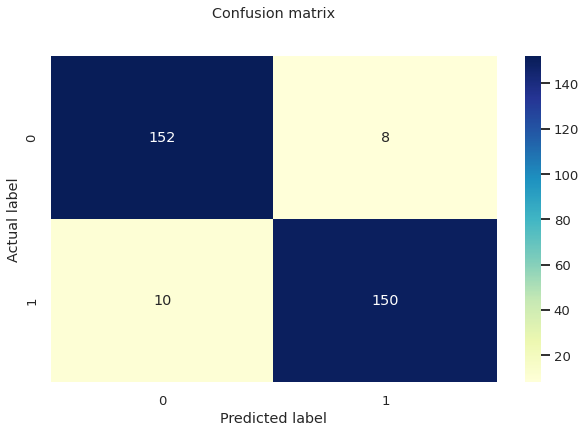

In [87]:
from matplotlib.pyplot import figure
cnf_matrix=confusion_matrix(y_val,y_pred)

# Creating a Heatmap for the confusion matrix. 
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [88]:
###Save Model For prediction
import pickle
pickle.dump(v,open("feature.pkl","wb"))
pickle.dump(nb,open("naive_bayes_model.pkl","wb"))

### Prediction Test Data

In [89]:
df_test=pd.read_excel(r"NLP Engineer -Test Dataset.xlsx",engine='openpyxl')
df_test.head()

,Conversations,Patient Or not
0,Just been to GP for annual health check.Suspec...,NaN
1,"Hello, So, I am a 52 year old female.Had the c...",NaN
2,From what I have read I think it helps determi...,NaN
3,It's disgusting isn't it. I've worked for 36 y...,NaN
4,Very interesting. I had to stop Enbrel because...,NaN


In [92]:
###Preprcess Test Data
def preprocessing(text):
    text = BeautifulSoup(text, 'html5lib').get_text() 
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) 
    text=contractions.fix(text)
    b = TextBlob(text) 
    text=basic_cleaning(str(b))
    text = re.sub('\W+',' ', text )
    text=lemmatize_words(text)
    return text

df_test['clean_Conversations']=df_test['Conversations'].apply(lambda x:preprocessing(x) )

In [93]:
### Vectorize Test Data
from sklearn.feature_extraction.text import TfidfVectorizer

x_test_tfidf = v.transform(df_test['clean_Conversations'].to_list())

In [94]:
y_test_pred=nb.predict(x_test_tfidf)